In [1]:
import os
import h5py 
import numpy as np 
from tqdm.auto import trange

In [2]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
seed = 1
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"
print(device)

cuda:0


In [5]:
# dat_dir = '/Users/chahah/data/goleta/'
dat_dir = '/tigress/chhahn/cgpop/'

In [6]:
ftng = h5py.File(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
tng = ftng['props'][...]

w_tng = np.loadtxt(os.path.join(dat_dir, 'camels_tng.omega_thetag.dat'), unpack=True, usecols=[-1])

# restrict only to centrals
is_central = np.loadtxt(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.iscen'))
is_central = is_central.astype(bool)

tng = tng[:,is_central]
w_tng = w_tng[is_central]

is_sf = (np.log10(tng[14])-np.log10(tng[7]) > -10.)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [7]:
high_baryons = (tng[6] + tng[7]) / tng[9] > 0.9
print('%.2f have >90 percent baryons' % np.mean(high_baryons))

0.03 have >90 percent baryons


In [8]:
tng = tng[:, is_sf & ~high_baryons]

In [9]:
hat_Mtot = torch.load(os.path.join(dat_dir, 'tng.hat_Mtot.sf.no_highb.pt'), map_location=device)

In [21]:
hat_epsilon = torch.load(os.path.join(dat_dir, 'tng.hat_epsilon.sf.no_highb.pt'), map_location=device)

In [30]:
Om = tng[0]
logAsn1 = np.log10(tng[2])

logMg = np.log10(tng[6])
logMs = np.log10(tng[7])
logMt = np.log10(tng[9])
logZs = np.log10(tng[13])
logRs = np.log10(tng[17])

logVmax = np.log10(tng[10])

logeps = np.log10((tng[0]/0.049) * (tng[7]/tng[9]))

In [12]:
Ntrain = int(0.9 * tng.shape[1])
print('Ntrain = %i' % Ntrain)
ishuffle = np.arange(tng.shape[1])
np.random.shuffle(ishuffle)

Ntrain = 226607


In [38]:
hat_Om = []
for i in trange(len(ishuffle)-Ntrain): 
    _x = np.array([logVmax[ishuffle[Ntrain+i]], logMg[ishuffle[Ntrain+i]], 
                   logMs[ishuffle[Ntrain+i]], logRs[ishuffle[Ntrain+i]], 
                   logAsn1[ishuffle[Ntrain+i]]])
    # sample posterior p(theta | x_test_i)
    logMtot_prime = hat_Mtot.sample((10000,), 
            x=torch.as_tensor(_x.astype(np.float32)).to(device), 
            show_progress_bars=False)
    logMtot_prime = np.array(logMtot_prime.detach().cpu())
    
    _x = np.array([logMs[ishuffle[Ntrain+i]], logMg[ishuffle[Ntrain+i]], 
                   logZs[ishuffle[Ntrain+i]], logRs[ishuffle[Ntrain+i]], 
                   logAsn1[ishuffle[Ntrain+i]]])
    
    # sample p(epsilon | x_test_i)
    logeps_prime = hat_epsilon.sample((10000,), 
            x=torch.as_tensor(_x.astype(np.float32)).to(device), 
            show_progress_bars=False)
    logeps_prime = np.array(logeps_prime.detach().cpu())
    
    #print(logMt[ishuffle[Ntrain+i]], np.mean(logMtot_prime))
    #print(logeps[ishuffle[Ntrain+i]], np.mean(logeps_prime))
    
    logMb = logMs[ishuffle[Ntrain+i]] - np.mean(logeps_prime)
    _hatOm = 0.049 / 10**logMb * 10**np.mean(logMtot_prime)
    #print(Om[ishuffle[Ntrain+i]], 0.049 / 10**(logMs[ishuffle[Ntrain+i]] - logeps[ishuffle[Ntrain+i]]) * 10**logMt[ishuffle[Ntrain+i]], _hatOm)
    
    hat_Om.append(_hatOm)

  0%|          | 0/25179 [00:00<?, ?it/s]

(0.1, 0.5)

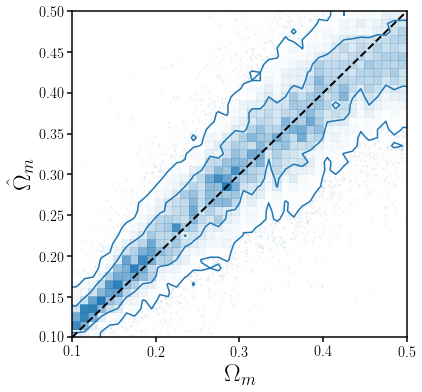

In [43]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
DFM.hist2d(Om[ishuffle[Ntrain:]], np.array(hat_Om), range=[(0.1, 0.5), (0.1, 0.5)], bins=40, color='C0', 
           levels=[0.68, 0.95])
sub.plot([0.1, 0.5], [0.1, 0.5], c='k', ls='--', lw=2)
sub.set_xlabel(r'$\Omega_m$', fontsize=25)
sub.set_xlim(0.1, 0.5)
sub.set_ylabel(r'$\hat{\Omega}_m$', fontsize=25)
sub.set_ylim(0.1, 0.5)